# Import Libraries

In [1]:
%%capture
!pip install pyDOE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == 'cuda': print(torch.cuda.get_device_name())

# Physics Informed Neural Network

In [3]:
class GrossPitaevskiiPINN(nn.Module):
    def __init__(self, layers, hbar=1.0, m=1.0):
        super(GrossPitaevskiiPINN, self).__init__()
        self.layers = layers
        self.network = self.build_network()
        self.g =  nn.Parameter(torch.tensor(0.0))  # Interaction strength, initialized as a learnable parameter
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed

    def build_network(self):
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:  # Activation for hidden layers
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def compute_potential(self, inputs, V0=1.0, x0=np.pi / 2, y0=np.pi / 2, sigma=0.5):
        """Compute the Gaussian potential V(x,y)."""
        x = inputs[:, 0]
        y = inputs[:, 1]
        V = V0 * torch.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
        return V

    def boundary_loss(self, x_bc, u_bc):
        """Computes the data loss (MSE) at the boundary."""
        u_pred = self.forward(x_bc)
        y_bc = torch.zeros_like(u_pred)  # Satisfy boundary conditions
        return torch.mean((u_pred - y_bc) ** 2)

    def riesz_loss(self, predictions, inputs):
        """Computes the Riesz energy loss for the Gross-Pitaevskii equation."""
        u = predictions

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.sum(gradients ** 2)  # Kinetic term
        V = self.compute_potential(inputs).unsqueeze(1)
        potential_term = torch.sum(V * u ** 2)  # Potential term
        interaction_term = 0.5 * self.get_interaction_strength() * torch.sum(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)
        return riesz_energy

    def pde_loss(self, inputs, predictions):
        """Computes the PDE loss for the Gross-Pitaevskii equation."""
        u = predictions

        # Compute gradients
        u_x = torch.autograd.grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Second derivatives of the Laplacian (∇²u)
        u_xx = torch.autograd.grad(u_x[:, 0], inputs, grad_outputs=torch.ones_like(u_x[:, 0]), create_graph=True)[0][:,0]
        u_yy = torch.autograd.grad(u_x[:, 1], inputs, grad_outputs=torch.ones_like(u_x[:, 1]), create_graph=True)[0][:,1]
        laplacian_u = u_xx + u_yy

        # Compute λ directly from the energy functional
        lambda_pde = torch.mean(laplacian_u + self.get_interaction_strength() * torch.abs(u ** 2) * u) / torch.mean(u ** 2)

        # Residual of the PDE (Gross-Pitaevskii equation)
        pde_residual = -laplacian_u + self.get_interaction_strength() * torch.abs(u ** 2) * u - (lambda_pde * u)

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Regularization term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to
        # avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)  # Add small constant to avoid division by zero

        # Regularization term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Regularization term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        c = 1.0  # Tunable
        L_drive = torch.exp(-lambda_pde + c)

        # PDE loss as the residual
        pde_loss = torch.mean(pde_residual ** 2) + L_f + L_lambda

        return pde_loss, pde_residual, lambda_pde

    def total_loss(self, x, x_bc, u_bc):
        """Total loss combining the different loss components."""
        data_loss = self.boundary_loss(x_bc, u_bc)
        riesz_energy = self.riesz_loss(self.forward(x), x)
        pde_loss, _, _ = self.pde_loss(x, self.forward(x))
        return data_loss + riesz_energy + pde_loss

    def get_interaction_strength(self):
        """Transform the learnable parameter g to the range [0, 500] using sigmoid."""
        return 500 * torch.sigmoid(self.g)  # Scale g to the range [0, 500]

# Initialize Weights

In [4]:
def initialize_weights(m):
    """Initialize weights for the neural network layers."""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Interaction Strength

In [5]:
def get_interaction_strength(self):
    """Transform the learnable parameter g to the range [0, 500] through a sigmoid."""
    return 500 * torch.sigmoid(self.g)  # Scale g to the range [0, 500]

# Prepare Training Data

In [6]:
def prepare_training_data(N_u, N_f, center=(np.pi / 2, np.pi / 2), radius=np.pi / 2):
    # Generate boundary points along the circular edge
    theta = np.linspace(0, 2 * np.pi, N_u)
    circle_x = center[0] + radius * np.cos(theta)
    circle_y = center[1] + radius * np.sin(theta)
    X_u_train = np.column_stack((circle_x, circle_y))
    u_train = np.zeros((X_u_train.shape[0], 1))  # Boundary condition u=0

    # Generate collocation points within the effective circular region
    collocation_points = []
    while len(collocation_points) < N_f:
        random_angle = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, radius)
        random_x = center[0] + r * np.cos(random_angle)
        random_y = center[1] + r * np.sin(random_angle)
        collocation_points.append([random_x, random_y])

    X_f_train = np.array(collocation_points)
    return X_f_train, X_u_train, u_train

# Prepare Test Data

In [7]:
def prepare_test_data(X, Y):
    """
    Prepare test data by flattening the 2D grids and stacking them column-wise.

    Parameters
    ----------
    X : np.ndarray
        2D grid points in the x-dimension as a NumPy array.
    Y : np.ndarray
        2D grid points in the y-dimension as a NumPy array.

    Returns
    -------
    X_u_test : np.ndarray
        Test data prepared by stacking the flattened x and y grids.
    lb : np.ndarray
        Lower bound for the domain (boundary conditions).
    ub : np.ndarray
        Upper bound for the domain (boundary conditions).
    """
    # Flatten the grids and stack them into a 2D array
    X_u_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

    # Domain bounds as NumPy arrays
    lb = np.array([0, 0], dtype=np.float32)
    ub = np.array([np.pi, np.pi], dtype=np.float32)

    return X_u_test, lb, ub

# Train PINN

In [8]:
def train_pinn(N_u=500, N_f=10000, layers=[2, 400, 400, 400, 1], epochs=1000):
    model = GrossPitaevskiiPINN(layers).to(device)  # Move model to device
    model.apply(initialize_weights)  # Apply weight initialization
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare training data
    X_f_train, X_u_train, u_train = prepare_training_data(N_u, N_f)

    # Convert data to PyTorch tensors and move to device
    X_f_train_tensor = torch.tensor(X_f_train, dtype=torch.float32, requires_grad=True).to(device)
    X_u_train_tensor = torch.tensor(X_u_train, dtype=torch.float32).to(device)
    u_train_tensor = torch.tensor(u_train, dtype=torch.float32).to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss
        loss = model.total_loss(X_f_train_tensor, X_u_train_tensor, u_train_tensor)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:  # Plot every 200 epochs
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}, g: {model.get_interaction_strength().item():.4f}')
            pde_loss, _, lambda_pde = model.pde_loss(X_f_train_tensor, model.forward(X_f_train_tensor))
            plot_solution(model, num_grid_pts=100, center=(np.pi/2, np.pi/2), radius=np.pi/2, epoch=epoch, lambda_pde=lambda_pde.item())

    return model

# Plot Solution

In [9]:
def plot_solution(model, num_grid_pts=100, center=(np.pi/2, np.pi/2), radius=np.pi/2, epoch=0, lambda_pde=0):
    x_vals = np.linspace(center[0] - radius, center[0] + radius, num_grid_pts)
    y_vals = np.linspace(center[1] - radius, center[1] + radius, num_grid_pts)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Prepare test data
    X_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Move to device

    # Predict the solution using the trained model
    u_pred = model(X_test_tensor).detach().cpu().numpy().reshape((num_grid_pts, num_grid_pts))

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.pcolor(X, Y, u_pred, shading='auto', cmap='viridis')
    plt.colorbar(label='Predicted Solution $u_{pred}$')
    plt.title(f'Predicted Solution of the Gross-Pitaevskii Equation\nEpoch: {epoch}, Smallest Eigenvalue: {lambda_pde:.4f}, g: {model.get_interaction_strength().item():.4f}')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim([center[0] - radius, center[0] + radius])
    plt.ylim([center[1] - radius, center[1] + radius])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(['Smallest Eigenvalue'])
    plt.show()

# Main

Epoch [0/1000], Loss: 17843.285156, g: 249.8750


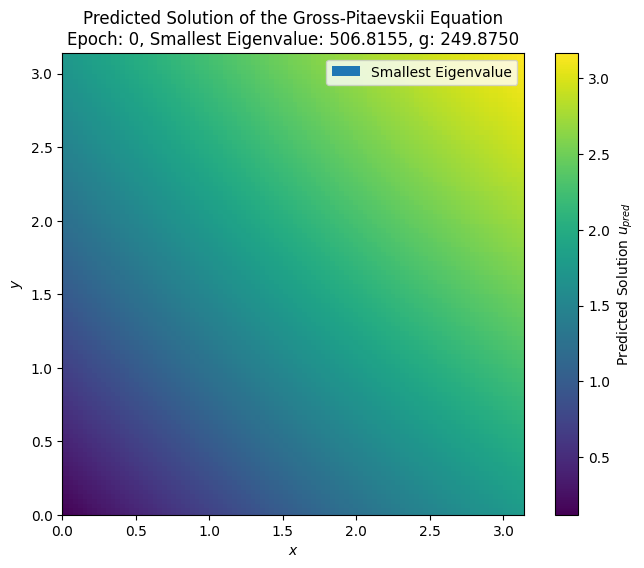

Epoch [200/1000], Loss: 96.389084, g: 248.5341


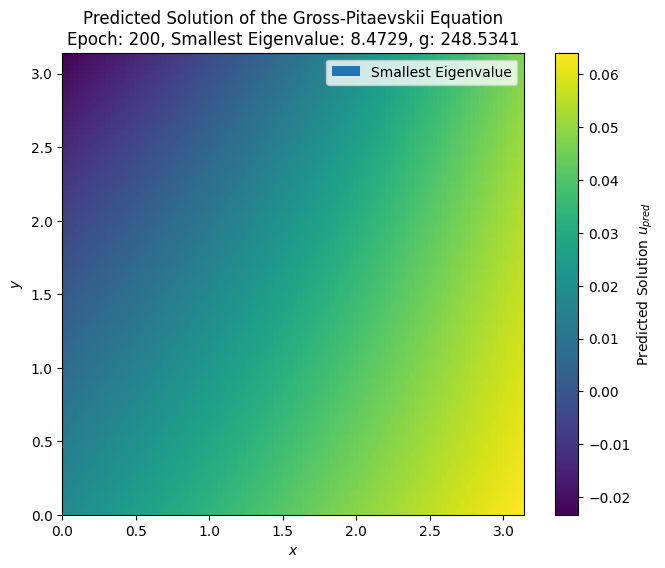

Epoch [400/1000], Loss: 90.969543, g: 248.5341


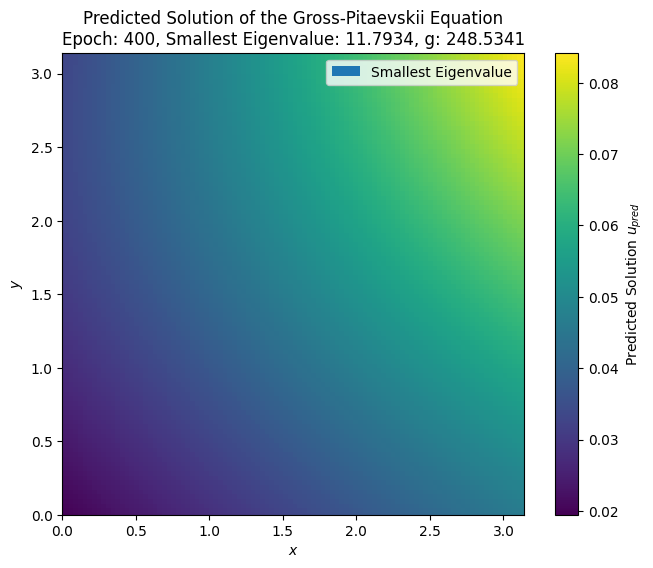

Epoch [600/1000], Loss: 90.797806, g: 248.5338


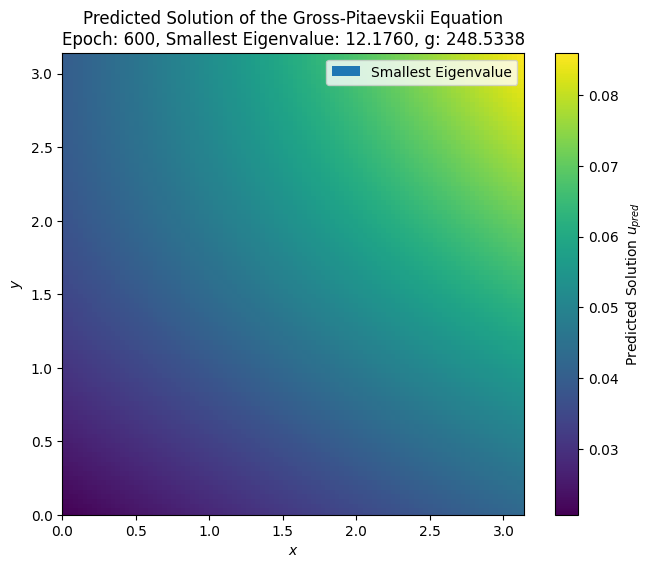

In [ ]:
N_u = 500  # Number of boundary points
N_f = 10000  # Number of collocation points
layers = [2, 400, 400, 400, 1]  # Neural network architecture
epochs = 1000  # Number of training epochs

# Train the PINN
model = train_pinn(N_u=N_u, N_f=N_f, layers=layers, epochs=epochs)

# Plot the predicted solution after training
plot_solution(model, num_grid_pts=100, center=(np.pi / 2, np.pi / 2), radius=np.pi / 2)